## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1) Camera calibration using chessboard images



In [44]:
# Intrinsic camera calibration
import os
#print(os.environ['DISPLAY'])
## Imports
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

## Read in image files
imgNames = glob.glob("camera_cal/*.jpg", recursive=False)

## Create object and image points
objPoints = [] # 3D points in real world space
imgPoints = [] # 2D points in image plane

objPts = np.zeros((9*6, 3), np.float32) 
objPts[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

## Loop through all chess images
### 1) Read in image
### 2) get shape of image
### 3) convert to grayscale for findChessboardCorners function
### 4) append objectpoints and imagepoints to lists for calibrateCamera function

for imgName in imgNames:
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objPoints.append(objPts)
        imgPoints.append(corners)
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow("img", img)
        #cv2.waitKey(500)

## Destroy all windows after drawing
#cv2.destroyAllWindows()
        
## Calibrate camera based on the objPoints and imgPoints lists
img = cv2.imread(imgNames[6]) # Take an example image for image size
imgSize = (img.shape[1], img.shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgSize, None, None)

## Save coefficients to file
intr_camera_calib = {}
intr_camera_calib["mtx"] = mtx
intr_camera_calib["dist"] = dist
pickle.dump(intr_camera_calib, open("camera_cal/intr_camera_calib.p", "wb"))

print("Done")

Done


## 2) Applying intrinsic camera calibration values (camera matrix & distortion coefficients) to raw images

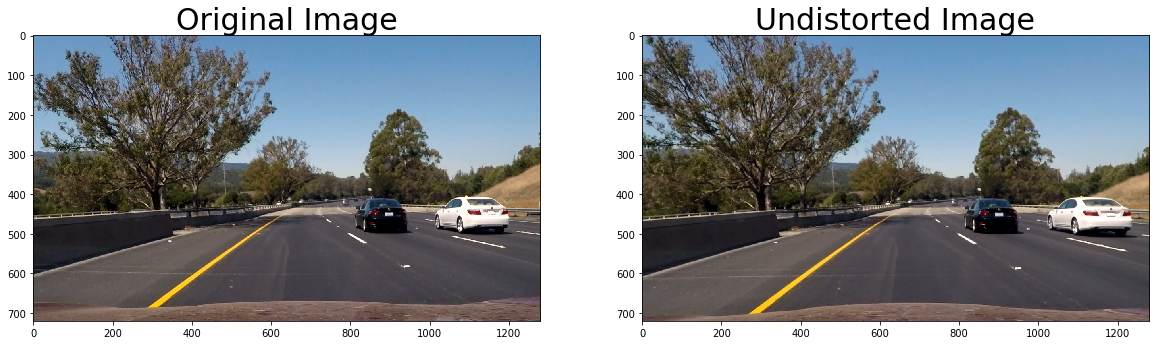

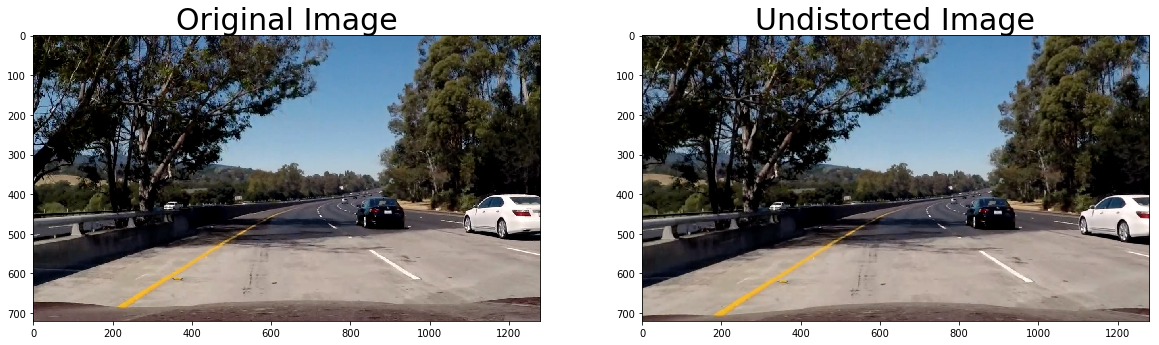

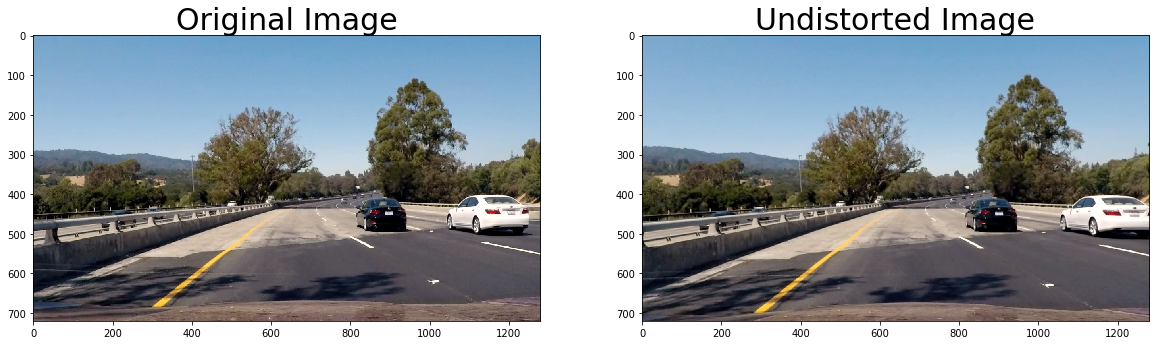

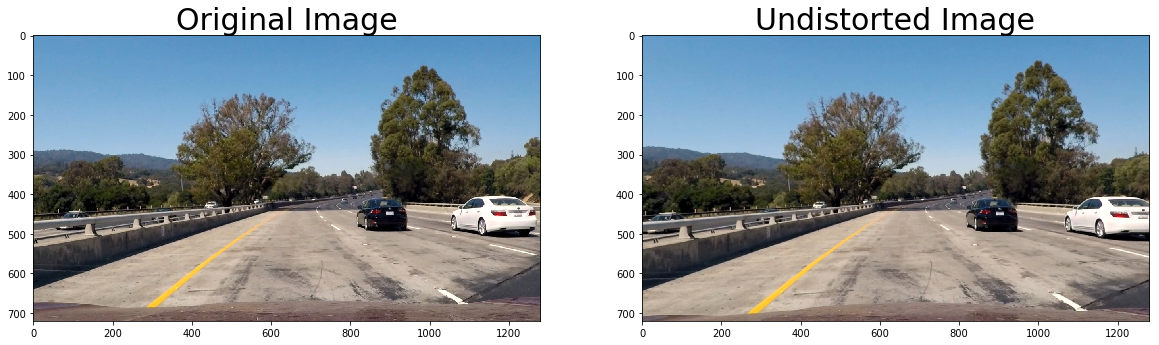

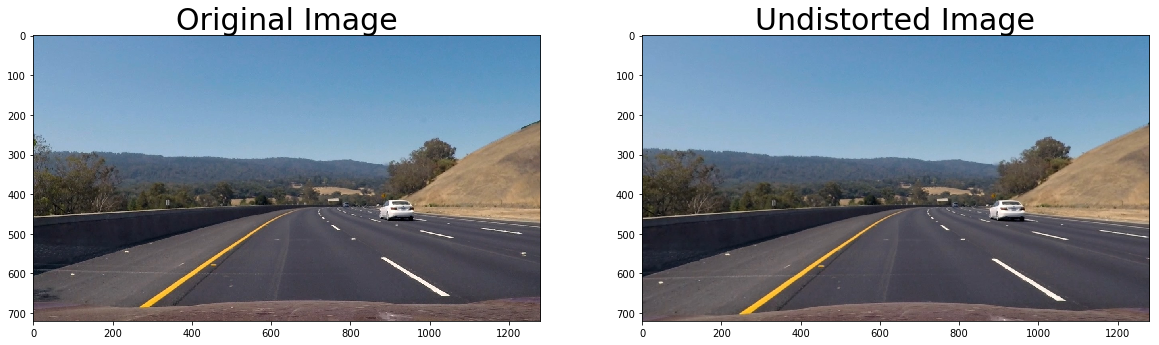

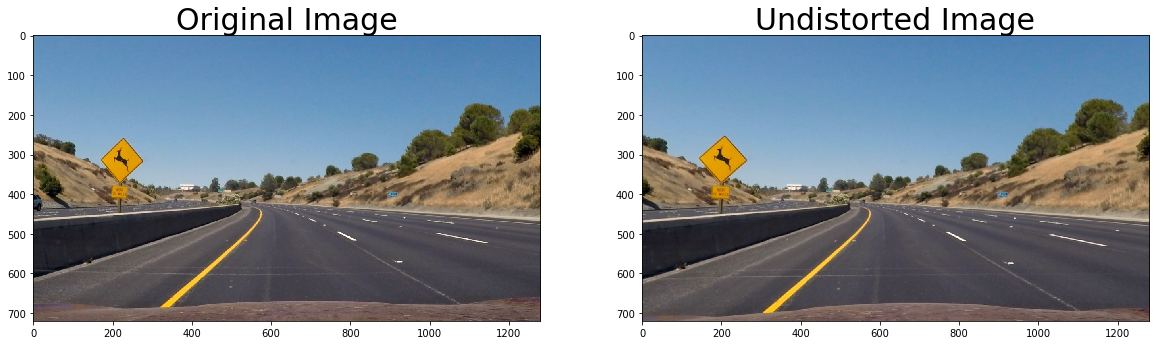

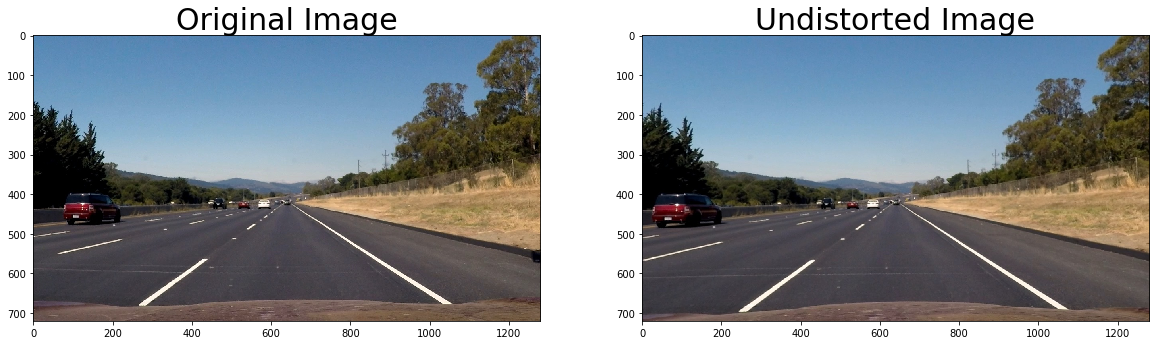

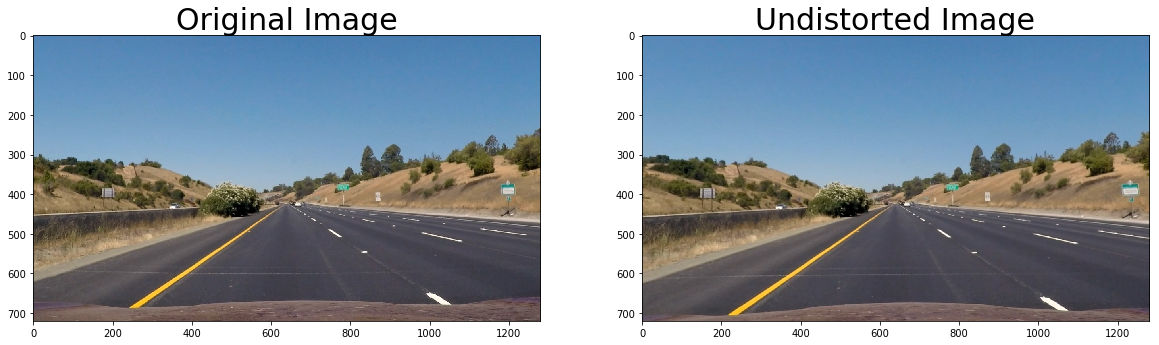

In [45]:
# Distortion correction to raw images
## Imports
import matplotlib.pyplot as plt
%matplotlib inline

## Visualize undistortion
def visualize(img, img2, title1="Original Image", title2="Undistorted Image", color2="gray"):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title(title1, fontsize=30)
    if color2 == "gray":
        ax2.imshow(img2, cmap="gray")
    else:
        ax2.imshow(img2)   
    ax2.set_title(title2, fontsize=30)
    return f
    
## Read in intrinsic camera values
intr_camera_calib = {}
with open('camera_cal/intr_camera_calib.p', 'rb') as handle:
    intr_camera_calib = pickle.load(handle)
mtx = intr_camera_calib["mtx"]
dist = intr_camera_calib["dist"]

## Read in raw image files
#imgNames = glob.glob("camera_cal/*.jpg", recursive=False)
imgNames=[]
for imgName in imgNames:
    ## Undistort example image from the given intrinsic camera matrix and distortion coefficient
    img = cv2.imread(imgName)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    ## Visualize original and undistorted image
    f = visualize(img, undist, title1="Original Image", title2="Undistorted Image")
    f.savefig(imgName.split(".")[0]+"_undist"+".jpg")

## Apply undistortion to the test images
## Read in image files
undist=[]
imgNames = glob.glob("test_images/*.jpg", recursive=False)
for imgName in imgNames:
    img = cv2.imread(imgName)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undst = cv2.undistort(img, mtx, dist, None, mtx)
    #undst = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist.append(undst)
    f = visualize(img, undst, title1="Original Image", title2="Undistorted Image")
    f.savefig(imgName.split("/")[0]+"/undist/"+imgName.split("/")[1].split(".")[0]+"_undist"+".jpg")



## 3) Color transforms, gradients, etc. for creating a binary image


8


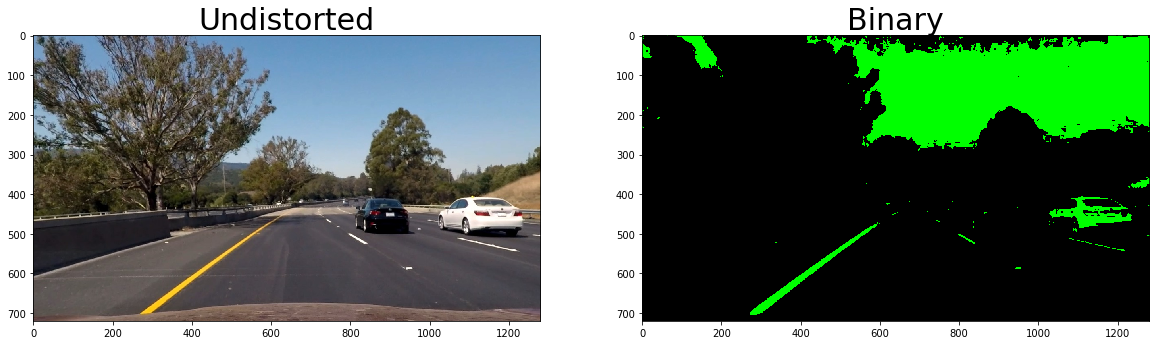

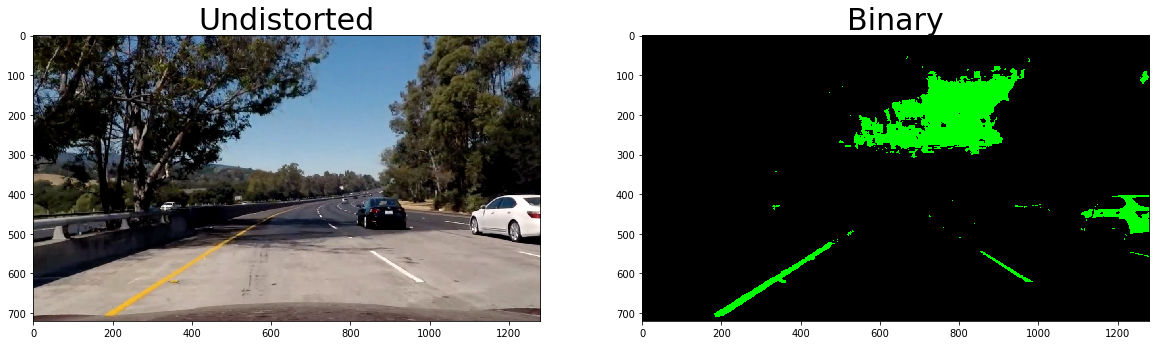

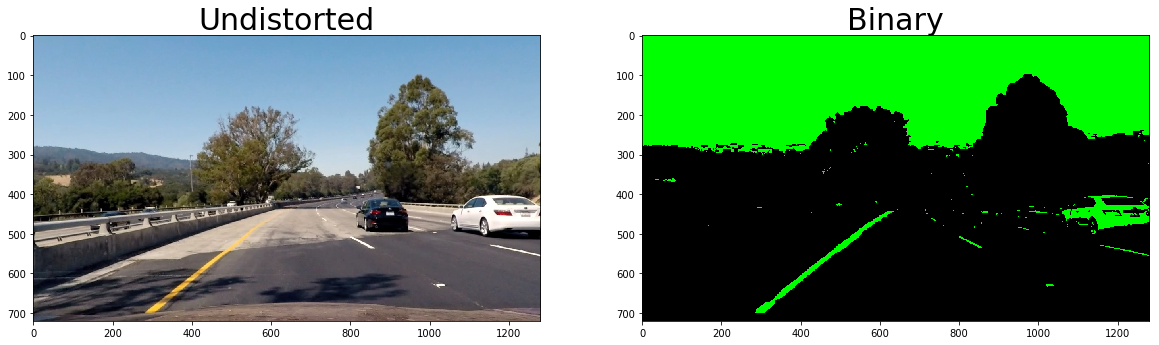

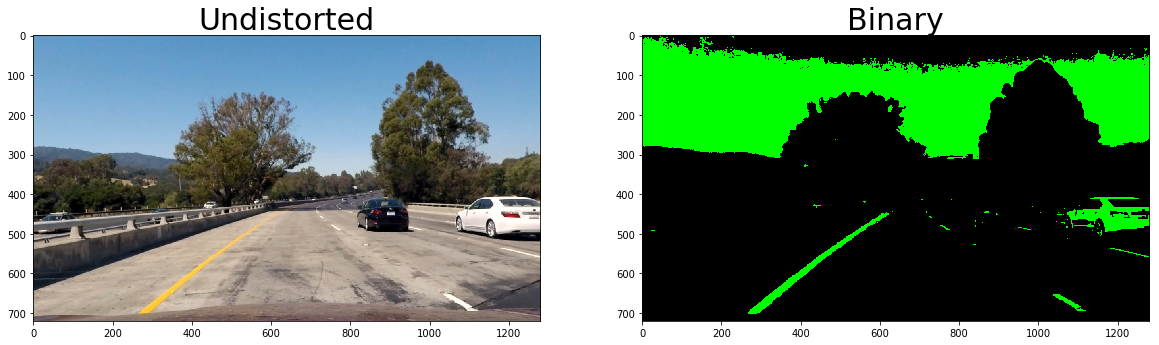

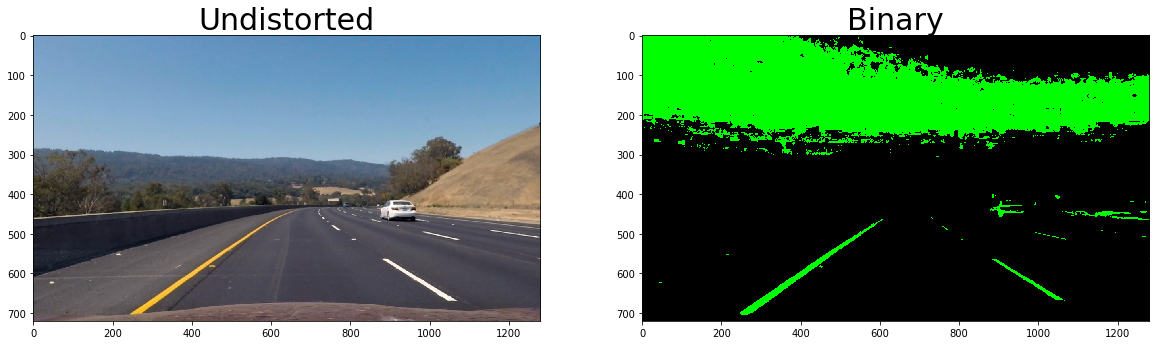

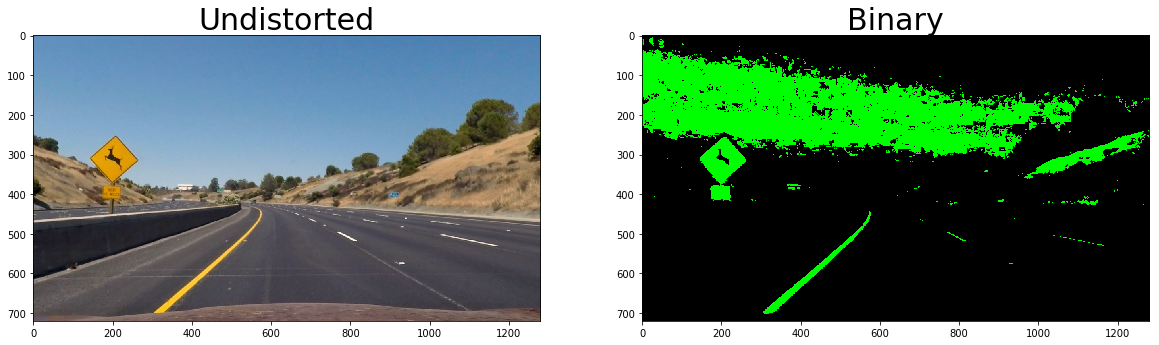

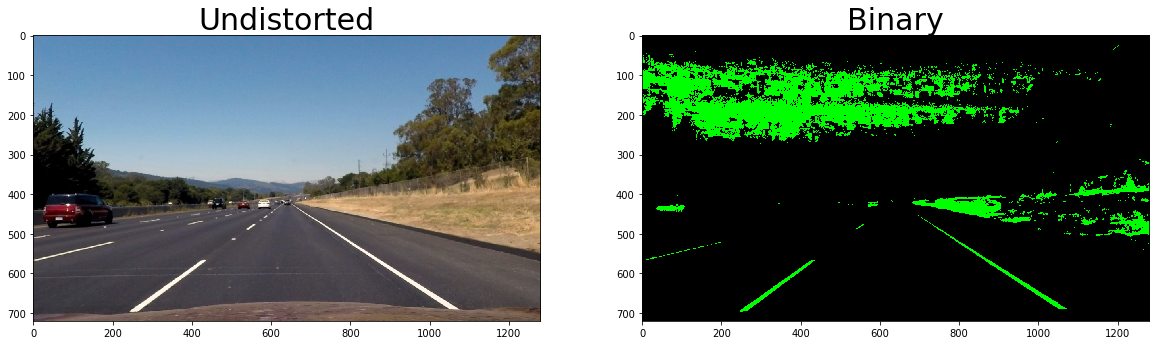

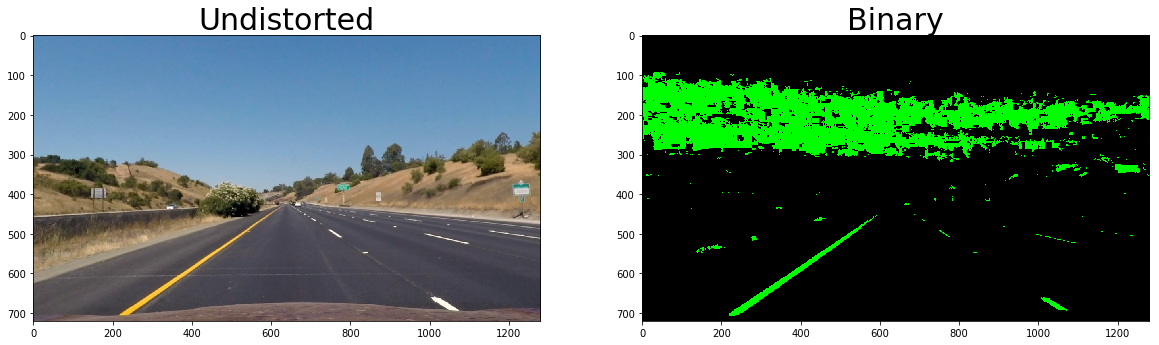

In [46]:
%matplotlib inline


## Binary select
def binary_select(channel, thresh=(0,255)):
    
    binary = np.zeros_like(channel)
    binary[(channel >= thresh[0]) & (channel <= thresh[1])] = 1
    return binary

## Gray onvert
def gray_convert(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

## RGB Select
def rgb_convert(img, channel='r'):
    # 1) Convert to HLS color space
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 
    
    # 2) Apply a threshold to the S channel
    if channel == 'b':
        chan = bgr[:,:,0]
    elif channel == 'g':
        chan = bgr[:,:,1]
    elif channel == 'r':
        chan = bgr[:,:,2]
    else:
        raise InputError("Channel must be r, g or b!")
    return chan

## HSV Convert
def hsv_convert(img, channel='h', thresh=(0,255)):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 2) Apply a threshold to the S channel
    if channel == 'h':
        chan = hsv[:,:,0]
    elif channel == 's':
        chan = hsv[:,:,1]
    elif channel == 'v':
        chan = hsv[:,:,2]
    else:
        raise InputError("Channel must be h, s or v!")
        
    return chan

## HLS Convert
def hls_convert(img, channel='h', thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # 2) Apply a threshold to the S channel
    if channel == 'h':
        chan = hls[:,:,0]
    elif channel == 'l':
        chan = hls[:,:,1]
    elif channel == 's':
        chan = hls[:,:,2]
    else:
        raise InputError("Channel must be h, l or s!")
        
    return chan

## Absolute sobel
def abs_sobel(image, orient='x', sobel_kernel=3, scale=False):

    # 1) Convert to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        raise SomeError("Error")
    # 2) & 3) Take the derivative in x or y given orient = 'x' or 'y'
    #         Take the absolute value of the derivative or gradient
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    if scale:
        abs_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    #scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # 6) Return this mask as your binary_output image

    return abs_sobel


## Magnitude sobel
def mag_sobel(image, sobel_kernel=3):

    # 1) Convert to grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    elif len(image.shape) == 2:
        gray = image
    else:
        raise SomeError("Error")

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 6) Return this mask as your binary_output image
    return scaled_sobel

## Directional Sobel
def dir_sobel(image, sobel_kernel=3, thresh=(0.7, 1.4)):

    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))

    # 3) Take the absolute value of the x and y gradients
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1

    # 6) Return this mask as your binary_output image
    return dir_binary

## Merge two binary images
def stack_channels(channel_a, channel_b, channel_c, scale=False):
    if scale:
        stacked = np.dstack(( channel_a, channel_b, channel_c)) * 255
    else:
        stacked = np.dstack(( channel_a, channel_b, channel_c))
    return stacked

binaries=[]

def colorPipeline(img):
    gray = gray_convert(img)
    binary_gray = binary_select(gray, thresh=(220,255))
    
    r_channel = rgb_convert(img, channel='r')
    binary_red = binary_select(r_channel, thresh=(100,255))
    
    s_channel = hls_convert(img, channel='s')
    binary_sat = binary_select(s_channel, thresh=(100,255)) # 120, 250
    
    return stack_channels(np.zeros_like(binary_red), (binary_red & binary_sat) + binary_gray, np.zeros_like(binary_red), scale=True)
    
    
for idx, img in enumerate(undist):
    ## TODO: Start with RGB --> Warum wird HLS oder HSV benutzt? Outsourcing von Farbwerten?
    ## First approach: Analyse single channels from color spaces 
    ## --> Get the channel with the biggest response to lines and combine with gradient and 
    ## binary select
    ## Result: Good for images with dark road and bright lanes or bright road and bright lanes
    ## but not both
    ## --> Need for combination of color channels
    #channel = hls_convert(img, channel='s')
    #gradient = abs_sobel(channel, orient='x', sobel_kernel=3, scale=True)
    #binary = binary_select(gradient, thresh=(50,255))
    #f = visualize2(img, binary)
    #f.savefig("test_images/binary/test_image_"+str(idx)+".jpg")
    
    ## Second approach, trying to rebuild and understand
    #l_channel = hls_convert(img, channel='l')
    #gradient = abs_sobel(l_channel, sobel_kernel=3, scale=True)
    #sx_binary = binary_select(gradient, thresh=(40,250)) # 20, 250
    #s_channel = hls_convert(img, channel='s')
    #s_binary = binary_select(s_channel, thresh=(180,250)) # 120, 250
    #stacked = stack_channels(np.zeros_like(sx_binary), np.zeros_like(sx_binary), sx_binary+s_binary, scale=True)
    #binaries.append(stacked)
    #f = visualize2(img, stacked)
    #f.savefig("test_images/binary/color_transformed/test_image_"+str(idx)+".jpg")
    
    ## Third approach
    # 1. grayscale + threshold --> white
    # 2. red channel --> yellow
    # 3. HLS --> saturation channel mostly
    # 4. Gradient --> lieber weglassen, da convoloution das besser macht vermutlich
    # 5. stack / combine
    stacked = colorPipeline(img)
    binaries.append(stacked)
    
    f = visualize(img, stacked, title1="Undistorted", title2="Binary")
    f.savefig("test_images/color_transformed/test_image_"+str(idx)+".jpg")
    
    
    
print(len(binaries))
    

## 4) Apply a perspective transform

In [47]:
#Perspective transform
%matplotlib inline


def warper(img, inverse=False):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(
        [[img_size[0] / 2 - 65, img_size[1] / 2 + 100],
        [img_size[0] / 6 - 10, img_size[1]],
        [img_size[0] * 5 / 6 + 60, img_size[1]],
        [img_size[0] / 2 + 65, img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    if inverse:
        temp=src
        src=dst
        dst=temp
    ## Get transformation-Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    ## return warped image
    return cv2.warpPerspective(img, M, img_size)
    
warped=[]
## Define source and destination image points for warping images
for idx, img in enumerate(binaries):
    

    ## Draw rectangle on image
    #cv2.line(img, tuple(src[0]), tuple(src[1]), (255,255,255), 2)
    #cv2.line(img, tuple(src[1]), tuple(src[2]), (255,255,255), 2)
    #cv2.line(img, tuple(src[2]), tuple(src[3]), (255,255,255), 2)
    #cv2.line(img, tuple(src[3]), tuple(src[0]), (255,255,255), 2)
    #cv2.imshow("org", img)
    #k = cv2.waitKey(0) # 0==wait forever

    warped_img = warper(img)
    warped.append(warped_img)
    #f = visualize3(img, warped[-1])
    #f.savefig("test_images/binary/warped/test_image_warped"+str(idx)+".jpg")
    #cv2.destroyAllWindows()

## 5) Detect lane pixels and fit to the lane boundary

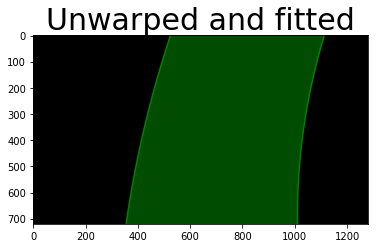

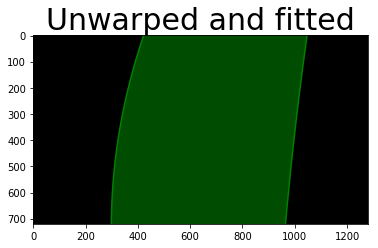

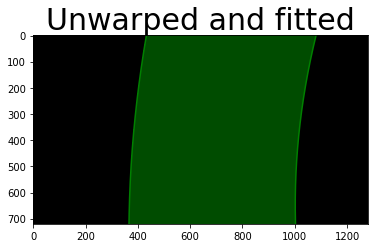

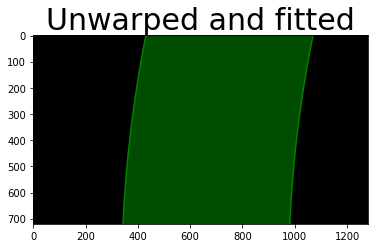

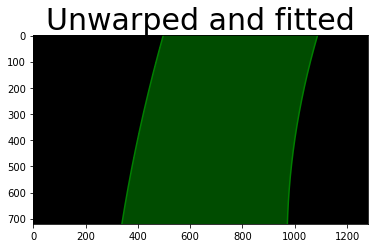

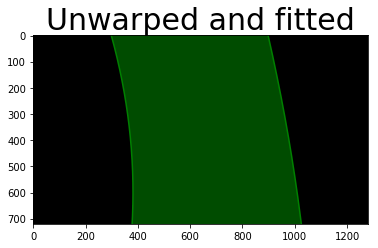

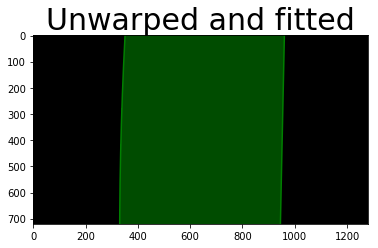

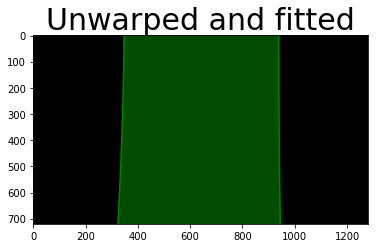

In [ ]:
# Detect lane pixels and fit polynomial to lane boundary
#%matplotlib qt


    
def visualize4(binary, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty):
    
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f = plt.figure()
    #ax1.imshow(org_img, cmap="gray")
    #ax1.set_title('Warped and fitted', fontsize=30)
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary, binary, binary))*255
    window_img = np.zeros_like(out_img)
    out_img2 = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area around the two lanes
    # And recast the x and y points into usable format for cv2.fillPoly()
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Generate a polygon to illustrate the search window area between the two lanes
    line_window1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
    line_pts = np.hstack((line_window1, line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img2, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='green')
    plt.plot(right_fitx, ploty, color='green')

    
    plt.imshow(result)
    
    plt.title('Unwarped and fitted', fontsize=30)
    
    ## Plots the left and right polynomials on the lane lines
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='green')
    #plt.plot(right_fitx, ploty, color='green')
    fitted.append(result)
    return f, result

def rest():

    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps 

    return result

def find_lane_pixels(binary_warped, draw_rectangles=False):
    
    ## Take a histogram of the bottom half of the image
    lower_half_img = binary_warped[binary_warped.shape[0]//2:,:]
    histogram = np.sum(lower_half_img, axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ## Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        if draw_rectangles:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,255,0), 4)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,255,0), 4)

        ## Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        ## If you found > minpix pixels, recenter next window 
        ## (`right` or `leftx_current`) on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("Error")
        pass

    # Extract left and right line pixel positions and return 
    return nonzerox[left_lane_inds], nonzeroy[left_lane_inds], nonzerox[right_lane_inds], nonzeroy[right_lane_inds]

def getOffset(img_size, left_fitx, right_fitx):
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx_base = left_fitx[-1]
    rightx_base = right_fitx[-1]
    offset_pixel = np.abs((leftx_base + (rightx_base - leftx_base) / 2) - img_size[1] / 2)
    offset = np.around(offset_pixel * xm_per_pix, 3)
    
    return offset
    

def fit_polynomial(leftx, lefty, rightx, righty, order=2):

    ## Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

def calc_polynomial_pts(shape, left_fit, right_fit):
    ## Generate x and y values for plotting
    ploty = np.linspace(0, shape[0]-1, shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        ## Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty


def search_around_poly(binary_warped, left_fit, right_fit):

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ## Set the area of search based on activated x-values  
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) +
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) +
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))

    
    
    # Again, extract left and right line pixel positions
    return nonzerox[left_lane_inds], nonzeroy[left_lane_inds], nonzerox[right_lane_inds], nonzeroy[right_lane_inds]



# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

left_fit_list = []
right_fit_list = []
ploty_list = []
fitted=[]

for idx, img in enumerate(warped):
    ## Take the green channel from RGB, since that is where we saved our combined binary output from the color transform
    binary = img[:,:,1]

    ## Find lane pixels first with sliding window
    leftx, lefty, rightx, righty = find_lane_pixels(binary, draw_rectangles=False)
    ## Fit new polynomials with easier search around the found polynomial
    #leftx, lefty, rightx, righty = search_around_poly(binary, left_fit, right_fit)    
    #print()
    ## Fit polynomial and calculate points 
    left_fit, right_fit = fit_polynomial(leftx, lefty, rightx, righty, order=2)
    left_fitx, right_fitx, ploty = calc_polynomial_pts(binary.shape, left_fit, right_fit)
    offset = getOffset(binary.shape, left_fitx, right_fitx)
    left_fit_list.append(left_fit)
    right_fit_list.append(right_fit)
    ploty_list.append(ploty)
    f, result = visualize4(binary, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
    f.savefig("test_images/fitted/test_image_rectangle"+str(idx)+".jpg")



## 6) Determine the curvature and the offset of the lane

In [ ]:
# Measure curvature
left_curverad_list = []
right_curverad_list = []

def measure_curvature_pixels(ploty, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ## Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1+(2*left_fit[0]*y_eval+left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*right_fit[0]*y_eval+right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])  ## Implement the calculation of the right line here
    
    calc_polynomial_pts(binary.shape, left_fit, right_fit)
    
    return left_curverad, right_curverad

for idx in range(len(left_fit_list)):
    left_curverad, right_curverad = measure_curvature_pixels(ploty_list[idx], left_fit_list[idx], right_fit_list[idx])
    left_curverad_list.append(left_curverad)
    right_curverad_list.append(right_curverad)
    
print(left_curverad_list, right_curverad_list)



[3912.7792168202327, 2158.5175934815747, 4477.6373528284439, 4770.1970848061756, 6226.6898154020564, 2181.8687405116857, 14871.107635140132, 16056.708165686225] [2282.5989751096658, 14090.822635164321, 2644.4401757187511, 4516.4023711606396, 2753.3064791234883, 7099.6190330062109, 375213.46471240453, 43582.871967809733]


## 7) Warp the detected lane boundaries back and visualize

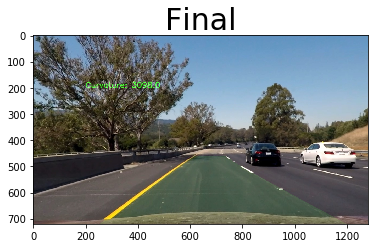

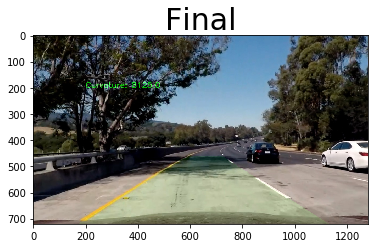

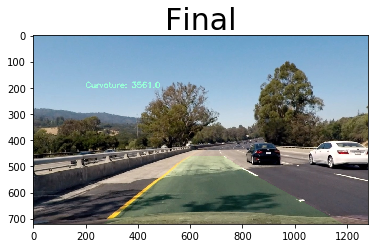

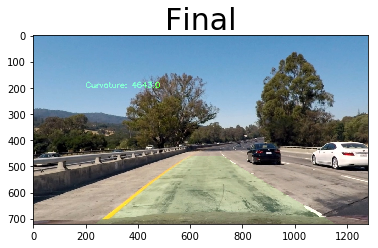

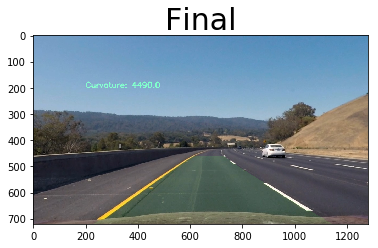

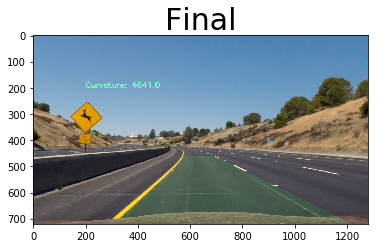

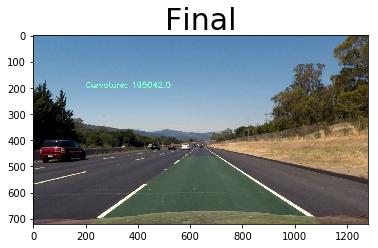

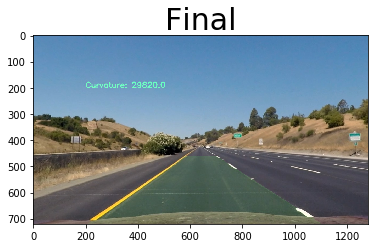

In [ ]:
## Visualize undistortion
def visualize5(img, img2, img3, title1="Original Image", title2="Undistorted Image", color2="gray", curvature=0):
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f = plt.figure()
    #ax1.imshow(img)
    #ax1.set_title(title1, fontsize=30)
    #ax2.imshow(img2)
    
    window_img = np.zeros_like(img)
    cv2.putText(window_img, "Curvature: "+str(curvature), (200,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    result = cv2.addWeighted(img, 1, img3, 0.3, 0)
    result = cv2.addWeighted(result, 1, window_img, 0.7, 0)
    plt.imshow(result)
    plt.title(title2, fontsize=30)
    return f

for idx, fit in enumerate(fitted):
    unwarped = warper(fit, inverse=True)
    
    f = visualize5(undist[idx], fit, unwarped, title1="Warped", title2="Final", curvature=np.around(np.mean([left_curverad_list[idx], right_curverad_list[idx]]),0))
    f.savefig("test_images/unwarped/test_image_"+str(idx)+".jpg")

## 8) Video test

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
#%matplotlib inline


class Final_Pipeline():
    
    def __init__(self):
        self.start = True
        self.left_fit = None
        self.right_fit = None
    
    def go(self, frame):
        ## 1) Undistort 
        undst = cv2.undistort(frame, mtx, dist, None, mtx)

        ## 2) Color transform
        binary = colorPipeline(undst)

        ## 3) Warp
        warp = warper(binary)

        ## 4) Find pixels
        binary = warp[:,:,1]
        if self.start:
            self.start=False
            leftx, lefty, rightx, righty = find_lane_pixels(binary, draw_rectangles=False)
        else:
            leftx, lefty, rightx, righty = search_around_poly(binary, self.left_fit, self.right_fit)    
        self.left_fit, self.right_fit = fit_polynomial(leftx, lefty, rightx, righty, order=2)
        left_fitx, right_fitx, ploty = calc_polynomial_pts(binary.shape, self.left_fit, self.right_fit)
        f, result = visualize4(binary, leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)
        left_curv, right_curv = measure_curvature_pixels(ploty, self.left_fit, self.right_fit)
        curv = np.around(np.mean([left_curv, right_curv]),0)
        offset = getOffset(binary.shape, left_fitx, right_fitx)
        ## 5) Unwarp and visualize
        unwarped = warper(result, inverse=True)
        cv2.putText(undst, "Curvature: "+str(curv), (500,650), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(undst, "Lane Offset: "+str(offset), (500,700), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, cv2.LINE_AA)
        
        result = cv2.addWeighted(undst, 1, unwarped, 0.7, 0)

        # Display the resulting frame
        #cv2.imshow('Frame', result)
        return result

    
fp = Final_Pipeline()
#result = final_pipeline(undist[0])

project_input = 'project_video.mp4'
challenge_input = 'challenge_video.mp4'

project_output = 'out_project_video.mp4'
challenge_output = 'out_challenge_video.mp4'

clip3 = VideoFileClip(project_input).subclip(0,10)
challenge_clip = clip3.fl_image(fp.go)
%time challenge_clip.write_videofile(project_output, audio=False)
# Closes all the frames
cv2.destroyAllWindows()




[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4





  0%|          | 0/251 [00:00<?, ?it/s]


  0%|          | 1/251 [00:00<01:20,  3.10it/s]


  1%|          | 2/251 [00:00<01:42,  2.43it/s]


  1%|          | 3/251 [00:01<01:34,  2.61it/s]


  2%|▏         | 4/251 [00:01<01:41,  2.44it/s]


  2%|▏         | 5/251 [00:02<01:32,  2.65it/s]


  2%|▏         | 6/251 [00:02<01:24,  2.89it/s]


  3%|▎         | 7/251 [00:02<01:19,  3.06it/s]


  3%|▎         | 8/251 [00:02<01:13,  3.30it/s]


  4%|▎         | 9/251 [00:03<01:11,  3.38it/s]


  4%|▍         | 10/251 [00:03<01:18,  3.09it/s]


  4%|▍         | 11/251 [00:04<01:40,  2.39it/s]


  5%|▍         | 12/251 [00:07<04:48,  1.21s/it]


  5%|▌         | 13/251 [00:07<03:43,  1.07it/s]


  6%|▌         | 14/251 [00:07<02:51,  1.38it/s]


  6%|▌         | 15/251 [00:07<02:13,  1.76it/s]


  6%|▋         | 16/251 [00:08<01:53,  2.06it/s]


  7%|▋         | 17/251 [00:08<01:32,  2.54it/s]


  7%|▋         | 18/251 [00:08<01:17,  2.99it/s]


  8%|▊         | 19/251 [00:08<01:07,  3.43it/

 54%|█████▍    | 136/251 [00:49<00:33,  3.47it/s]


 55%|█████▍    | 137/251 [00:49<00:33,  3.44it/s]


 55%|█████▍    | 138/251 [00:49<00:40,  2.78it/s]


 55%|█████▌    | 139/251 [00:50<00:40,  2.73it/s]


 56%|█████▌    | 140/251 [00:50<00:37,  2.98it/s]


 56%|█████▌    | 141/251 [00:50<00:34,  3.22it/s]


 57%|█████▋    | 142/251 [00:51<00:34,  3.19it/s]


 57%|█████▋    | 143/251 [00:51<00:39,  2.74it/s]


 57%|█████▋    | 144/251 [00:52<00:43,  2.48it/s]


 58%|█████▊    | 145/251 [00:52<00:43,  2.41it/s]


 58%|█████▊    | 146/251 [00:53<00:45,  2.31it/s]


 59%|█████▊    | 147/251 [00:53<00:39,  2.64it/s]


 59%|█████▉    | 148/251 [00:53<00:35,  2.89it/s]


 59%|█████▉    | 149/251 [00:53<00:32,  3.16it/s]


 60%|█████▉    | 150/251 [00:54<00:29,  3.43it/s]


 60%|██████    | 151/251 [00:54<00:28,  3.51it/s]


 61%|██████    | 152/251 [00:54<00:28,  3.47it/s]


 61%|██████    | 153/251 [00:55<00:34,  2.88it/s]


 61%|██████▏   | 154/251 [00:55<00:30,  3.17it/s]


 62%|██████▏

[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 

CPU times: user 1min 23s, sys: 7.51 s, total: 1min 31s
Wall time: 1min 29s
